In [1]:
import os
import torch
import matplotlib.pyplot as plt
import xml.dom.minidom
from skimage.io import imread
from skimage import img_as_ubyte
from pyrr import Matrix44, Vector4, Vector3
import pyrr

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, 
    BlendParams,
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    HardPhongShader,
    SoftSilhouetteShader
)
from pytorch3d.renderer.cameras import look_at_view_transform

from torch_openpose.body import Body
from torch_openpose import util
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tqdm import tqdm
import torch.nn as nn
import imageio
import cv2
import copy
import glob
import random

import wandb

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d

from pytorch3d_utils import (
    mitsuba_scene_to_torch_3d_no_ground, 
    where, 
    add_background_batch, 
    get_body_image_from_mesh,
    get_scenes_filenames,
    get_background_filenames,
    pose_loss_single_human
)

In [5]:
def get_image_and_score(
        test_mesh, 
        test_camera,
        test_opt, 
        model, 
        body_estimation, 
        renderer,
        silhouette_renderer,
        orig_shape = (512, 512, 3)
    ):
    test_backgrounds = get_background_filenames('../data/backgrounds/test/')
    test_background = random.sample(test_backgrounds, 1)[0]
    (canvas_orig, 
     candidate_orig,
     subset_orig,
     heatmap_avg_orig,
     paf_avg_orig) = get_body_image_from_mesh(
        test_mesh, 
        body_estimation, 
        renderer,         
        silhouette_renderer,
        orig_shape, 
        test_background,
        test_camera
        )

    tex = torch.cat([model.texTshirt, model.texOther]).repeat(1, 1, 1)
    textures = Textures(verts_rgb=tex.cuda())    
    noise_mesh = Meshes(verts=[test_opt["verticies"]], faces=[test_opt["faces"]], textures=textures)
    
    (canvas_noise, 
     candidate_noise,
     subset_noise,
     heatmap_avg_noise,
     paf_avg_noise) = get_body_image_from_mesh(
        noise_mesh, 
        body_estimation, 
        renderer,         
        silhouette_renderer,
        orig_shape, 
        test_background,
        test_camera
        )
    
    metric = pose_loss_single_human(subset_noise, subset_orig)
    
    return canvas_orig, canvas_noise, metric


def wandb_init(name):
    run = wandb.init(
        project = "mts_tshirt", 
        reinit = True,
        name = name,
        config={
            "epochs": 5,
            "learning_rate": 0.2,
            "batch_size": 8,
            "optimizer": 'ADAM'
        }
    )
    
    return run 




class Model(nn.Module):
    def __init__(self, texTshirt, texOther, renderer, silhouette_renderer, body_estimation, batch_size):
        super().__init__()
        self.device = torch.device("cuda:0")
        self.silhouette_renderer = silhouette_renderer
        self.renderer = renderer
        self.texOther = texOther
        self.body_estimation = body_estimation
        self.cur_meshes = None
        self.batch_size = batch_size
        
        self.texTshirt = nn.Parameter(
            torch.zeros_like(texTshirt).to(self.device)
        )
        
        ## loss functions
        self.objective = torch.nn.MSELoss()
        self.zero_heatmap = torch.zeros((self.batch_size, 19, 64, 64), device=self.device)
        self.zero_paf = torch.zeros((self.batch_size, 38, 64, 64), device=self.device)
        
        # lighting info
        self.ambient_color = torch.tensor([[0.5, 0.5, 0.5]]).repeat(self.batch_size, 1)
        self.diffuse_color = torch.tensor([[0.3, 0.3, 0.3]]).repeat(self.batch_size, 1)
        self.specular_color = torch.tensor([[0.2, 0.2, 0.2]]).repeat(self.batch_size, 1)
        self.bg_dir = '../data/backgrounds/train/'
        self.background_filename = get_background_filenames(self.bg_dir)
        
    def forward(self, verts, faces, R, T):
        tex = torch.cat([self.texTshirt, self.texOther]).repeat(self.batch_size, 1, 1)
        textures = Textures(verts_rgb=tex.cuda())
        self.cur_meshes = Meshes(verts=verts, faces=faces, textures=textures)

        cameras = OpenGLPerspectiveCameras(
            znear=0.1,
            zfar=1000,
            fov=15,
            degrees=True,
            device=device, 
            R=R, 
            T=T
        )
        mesh_centers = torch.mean(verts, 1)
        cam_centers = cameras.get_camera_center()

        direction = cam_centers - mesh_centers
        
        
        lights = DirectionalLights(
            device=device, 
            direction=direction,
            ambient_color=self.ambient_color,
            diffuse_color=self.diffuse_color,
            specular_color=self.specular_color
        )
        
        
        
        # sample random bg
        bg_paths = random.sample(self.background_filename, self.batch_size)
        # render and add bg
        final_images = add_background_batch(bg_paths, self.cur_meshes, self.renderer, self.silhouette_renderer, cameras=cameras, lights=lights)
        
        body_input = (final_images[..., :3] - 0.5).permute((0, 3, 1, 2)).float()
        paf, heat = self.body_estimation.model(body_input)
        
        ob_val_heat = self.objective(heat, self.zero_heatmap)
        ob_val_paf = self.objective(paf, self.zero_paf)
        
        # Calculate the silhouette loss
        loss = ob_val_heat + ob_val_paf
        return loss, final_images

In [7]:
ORIG_SHAPE = (512, 512, 3)
DATA_ROOT = 'data/radek'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_SET_NAME = 'tshirt_torch'
snapshot_name = f'../snapshots/vertex_color_bg_{DATA_SET_NAME}.npy'
train_dir = f'../data/{DATA_SET_NAME}/train'
test_dir = f'../data/{DATA_SET_NAME}/test'

train_scenes = get_scenes_filenames(train_dir)
test_scenes = get_scenes_filenames(test_dir)
print(len(train_scenes))
print(len(test_scenes))

master_scene = 'data/radek/00008_mesh88_animated.xml'
mesh, cameras, optmization_input = mitsuba_scene_to_torch_3d_no_ground(master_scene, DATA_ROOT)

100%|██████████| 200/200 [00:00<00:00, 653318.38it/s]


1800
200


In [8]:
raster_settings = RasterizationSettings(image_size=512, blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ), 
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
    )
)

blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)




Text(0.5, 1.0, 'Pytorch3d')

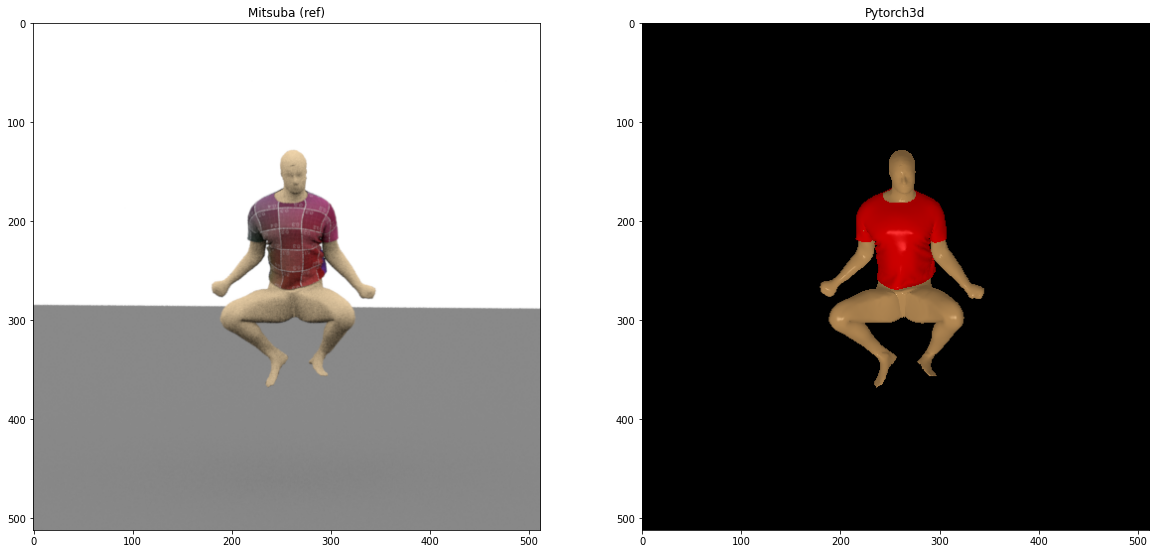

In [9]:
image = renderer(mesh)   # (1, H, W, 4)
ref_image = cv2.imread('data/radek/out.png')
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(ref_image)

ax.set_title("Mitsuba (ref)")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(image.squeeze().cpu().numpy())
ax.set_title("Pytorch3d")

In [10]:
run = wandb_init('torch3d directional light with bg')
batch_size = run.config.batch_size
epochs = run.config.epochs
steps = len(train_scenes) // batch_size
snapshot = '../snapshots/vertex_colors.npy'

body_estimation = Body('/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

# Initialize a model using the renderer, mesh and reference image
model = Model(
    texTshirt=optmization_input["texTshirt"], 
    texOther=optmization_input["texOther"], 
    renderer=renderer,
    silhouette_renderer=silhouette_renderer, 
    body_estimation=body_estimation,
    batch_size=batch_size
).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)


In [11]:
global_step = 0
for epoch in range(epochs):
    print(f"run {epoch + 1}/{epochs}")
    for step in tqdm(range(steps)):
        optimizer.zero_grad()
        
        batch_verts = []
        batch_faces = []
        batch_R = []
        batch_T = []
        
        for i in range(step * batch_size, (step * batch_size) + batch_size):
            _, _, opt_input = mitsuba_scene_to_torch_3d_no_ground(train_scenes[i], train_dir)
            batch_verts.append(opt_input["verticies"])
            batch_faces.append(opt_input["faces"])
            batch_R.append(opt_input["R"])
            batch_T.append(opt_input["T"])

        loss, cur_image = model(
            torch.stack(batch_verts), 
            torch.stack(batch_faces), 
            torch.stack(batch_R), 
            torch.stack(batch_T), 
        )
        
        loss.backward()
        optimizer.step()
        wandb.log({'loss': loss.item()}, step=global_step)
        global_step += 1
#         if global_step > 10:
#             break

final_texture = model.texTshirt.detach().cpu().numpy()
np.save(snapshot_name, final_texture)

  0%|          | 0/225 [00:00<?, ?it/s]

run 1/5


  0%|          | 0/225 [00:00<?, ?it/s]

run 2/5


  0%|          | 0/225 [00:00<?, ?it/s]

run 3/5


  0%|          | 0/225 [00:00<?, ?it/s]

run 4/5


  0%|          | 0/225 [00:00<?, ?it/s]

run 5/5


100%|██████████| 225/225 [16:21<00:00,  4.36s/it]


In [12]:
canvas_orig_list = []
canvas_noise_list = []
metric_list = []
i = 0
for test_scene in tqdm(test_scenes):
    test_mesh, test_camera, test_opt = mitsuba_scene_to_torch_3d_no_ground(test_scene, test_dir)
    
    canvas_orig, canvas_noise, metric = get_image_and_score(
        test_mesh, 
        test_camera,
        test_opt,
        model, 
        body_estimation, 
        renderer,
        silhouette_renderer
    )
    canvas_orig_list.append(canvas_orig)
    canvas_noise_list.append(canvas_noise)
    metric_list.append(metric)
    i += 1
#     if i > 9:
#         break

100%|██████████| 200/200 [04:43<00:00,  1.42s/it]


In [13]:
# filter where person was detected before altering
canvas_orig_list_filtered, canvas_noise_list_filtered, metric_list_filtered = zip(*(
    (canvas_orig, canvas_noise, metric) for canvas_orig, canvas_noise, metric in zip(canvas_orig_list, canvas_noise_list, metric_list) if metric >= 0)
)

In [14]:
print(f"Avg metric: {np.mean(metric_list_filtered)} of {len(metric_list_filtered)} test samples")
wandb.log({'avgMetric': np.mean(metric_list_filtered)})

Avg metric: 0.325189388937017 of 155 test samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

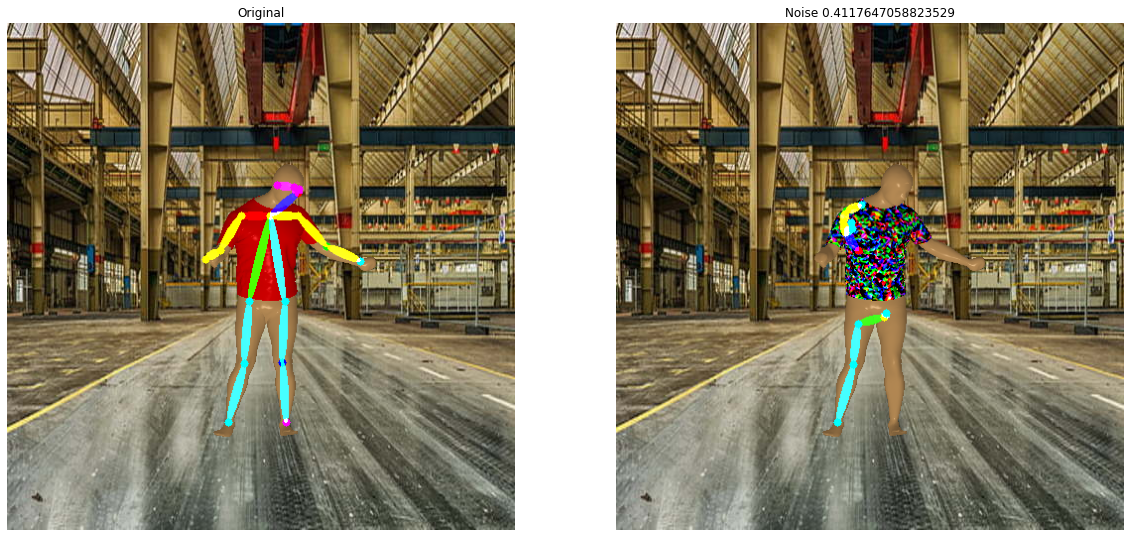

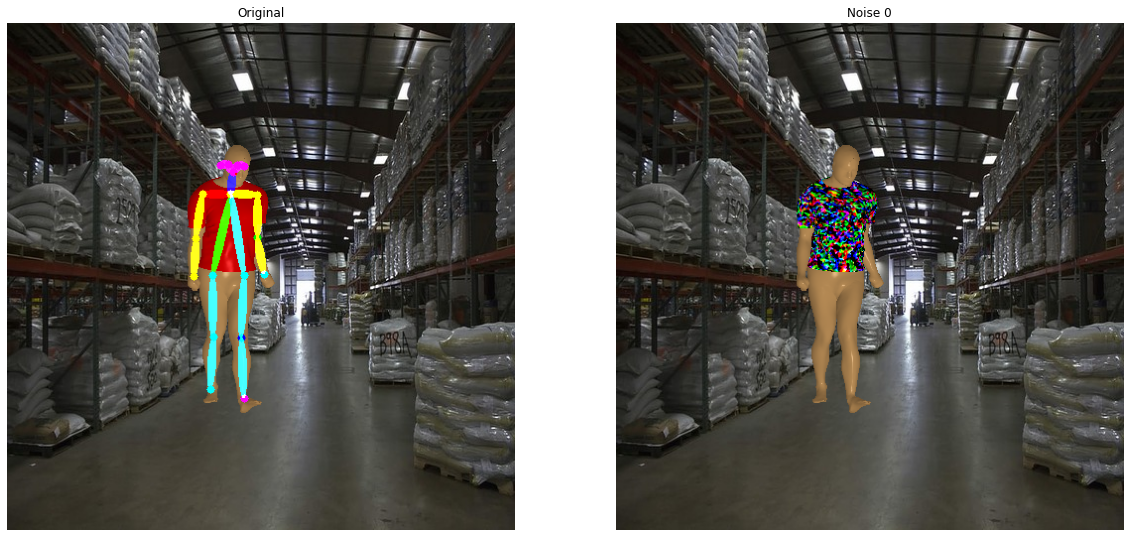

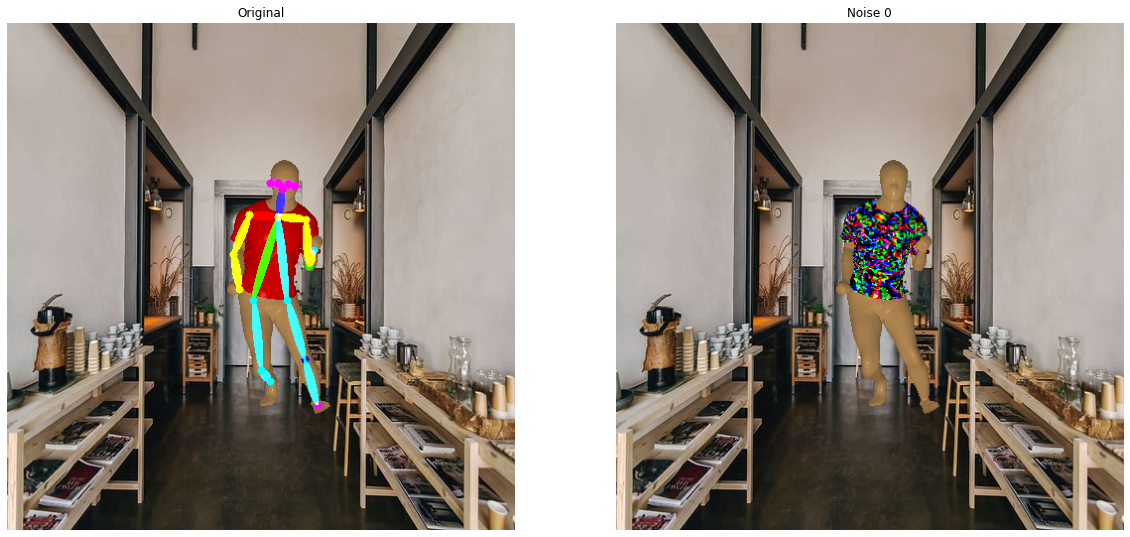

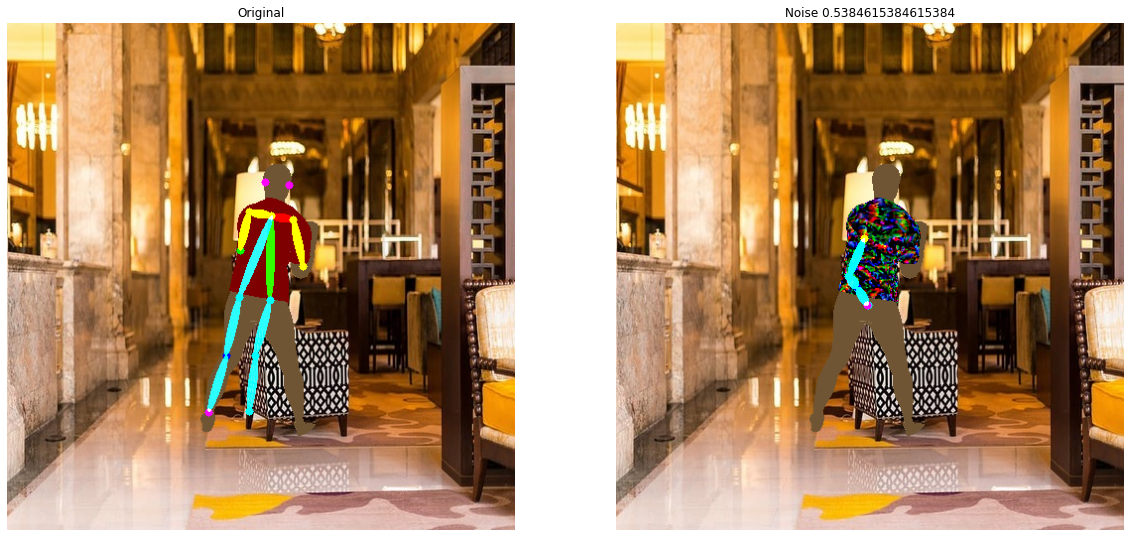

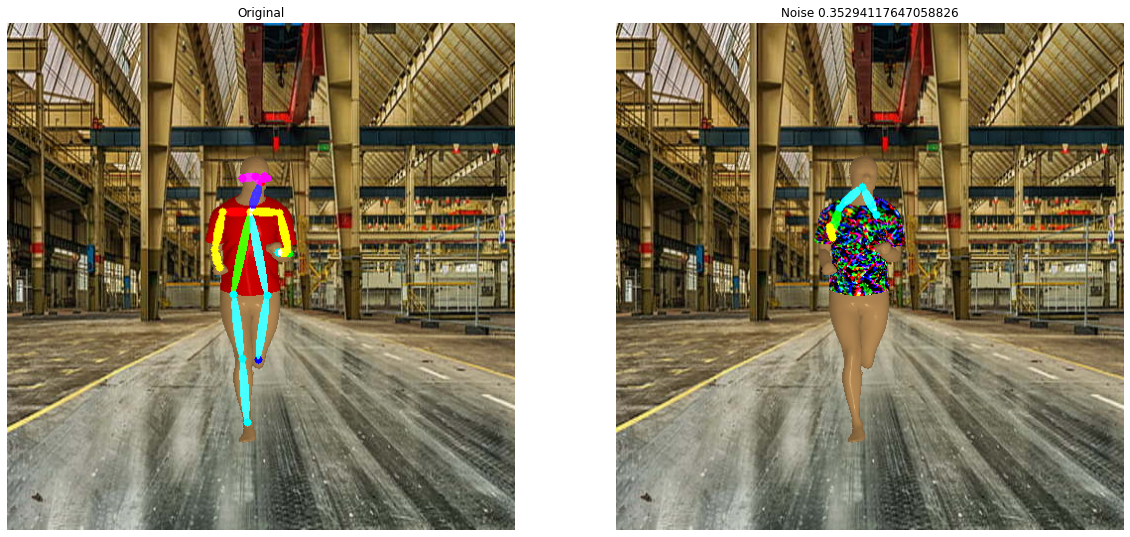

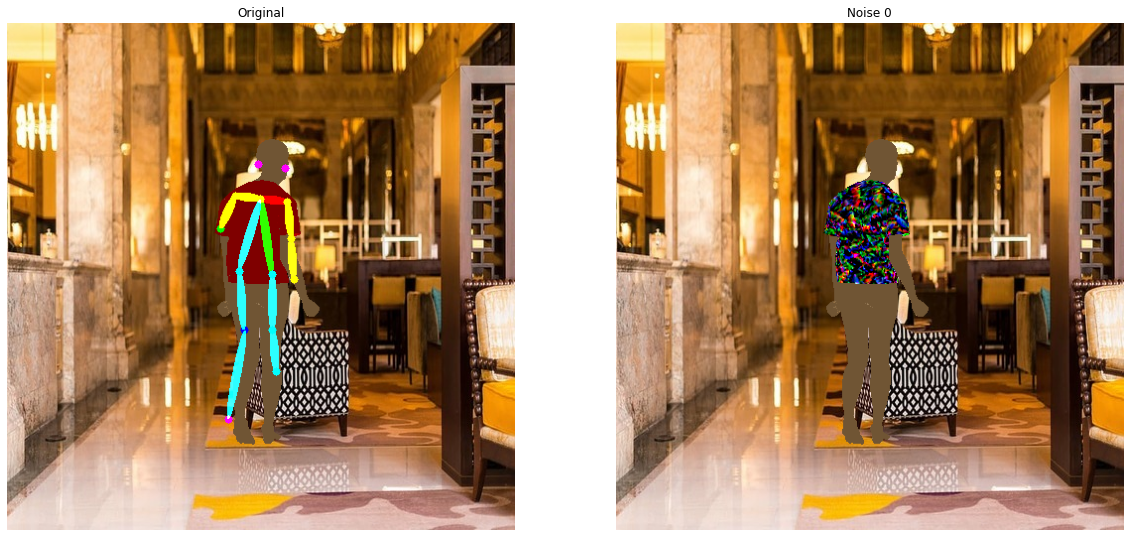

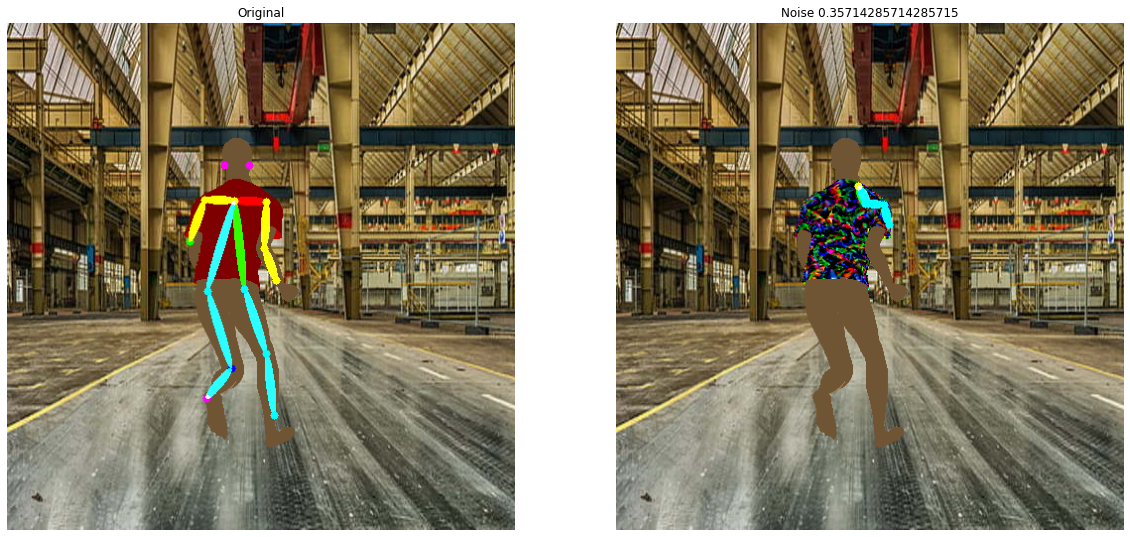

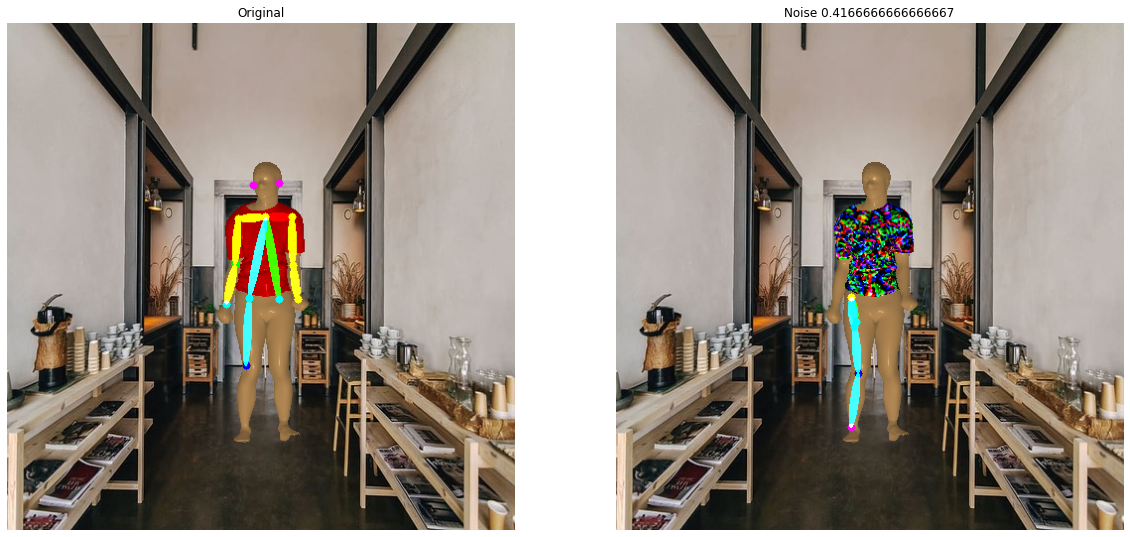

In [15]:
plot_cnt = 8
figures = []
for i in range(plot_cnt):
    fig = plt.figure(figsize=(20, 80))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(canvas_orig_list_filtered[i])
    ax.axis('off')
    ax.set_title('Original')

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(canvas_noise_list_filtered[i])
    ax.axis('off')
    ax.set_title(f'Noise {metric_list_filtered[i]}')